# Práctica 3 Aplicaciones de análisis 
## Series temporales 

Una serie de tiempo o serie temporal es una secuencia de datos, observaciones o valores, medidos en determinados momentos y ordenados cronológicamente. Los datos pueden estar espaciados a intervalos iguales o desiguales. 

Una vez que se captura una serie de tiempo, a menudo se realiza un análisis sobre ella para identificar patrones en los datos, en esencia, lo que se busca es entender que suceda a medida que el tiempo va avanzando. Ser capaz de procesar datos de series de tiempo es una habilidad esencial en el mundo moderno. 

Uno de los usos más habituales de las series de tiempo es su análisis para predicción y pronóstico (así se hace por ejemplo con los datos climáticos, las acciones de bolsa, o las series de datos demográficos).

In [1]:
# imports necesarios para la práctica
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
import statsmodels.tsa.seasonal as tsa
import statsmodels.graphics.tsaplots as tsaplots

import seaborn as sns

Lo primero que debemos hacer es cargar los datos en un formato "Serie Temporal". Resulta que **pandas** permite crear este tipo de datos con la función read_csv, así que podemos usarla para cargar los datos.
En esta práctica vamos a analizar y predecir la energía eólica del parque eólico Sotavento como una serie temporal. Para ello debéis utilizar el archivo Eolica.csv disponible en Moodle donde encontraréis tres años de datos diarios, con la siguiente información:
- Fecha
- Velocidad del viento (m/s)
- Dirección del viento
- Energía eólica producida (Kwh)

In [2]:
# cargamos los datos cogiendo la columna deseada de Wind Energy
df_eolica_completa = pd.read_csv('Eolica.csv', sep=',', header=0, usecols=[0,3], parse_dates=[0], dtype=np.float64,\
                        dayfirst=True, index_col=0)

print("Columnas:\n", list(df_eolica_completa.columns))

Columnas:
 ['Wind Energy']


Una vez cargados los datos, debemos comprobar que están bien. Pintemos los primeros datos de la serie con el comando **head**, pintemos el final con el comando **tail** y comprobemos el tamaño del dataset creado. Es importante para la posterior manipulación de la ST que cada punto tenga asociado un índice que indique su ordenación temporal. 

In [3]:
print(df_eolica_completa.head(10))
print("\n")
print(df_eolica_completa.tail(10))
print("\n")
print("num_rows: %d\tColumnas: %d\n" % (df_eolica_completa.shape[0], df_eolica_completa.shape[1]) )

            Wind Energy
Date                   
2016-01-01    280606.59
2016-01-02    181981.12
2016-01-03    329470.87
2016-01-04    216707.38
2016-01-05    204859.99
2016-01-06    278101.80
2016-01-07    247007.30
2016-01-08          NaN
2016-01-09          NaN
2016-01-10          NaN


            Wind Energy
Date                   
2018-12-22     95918.79
2018-12-23     43276.21
2018-12-24     13585.14
2018-12-25     18349.89
2018-12-26     21548.11
2018-12-27     10872.37
2018-12-28     18077.52
2018-12-29     85855.44
2018-12-30     63911.85
2018-12-31     31660.28


num_rows: 1096	Columnas: 1



In [4]:
# Podemos usar la fecha como índice y por ejemplo pintar los datos por año, mes o intervalo de meses
print("series['2016']:"); print(df_eolica_completa['2016'])
print("series['2016-01']:"); print(df_eolica_completa['2016-01'])
print("series['2016-01':'2016-06']:"); print(df_eolica_completa['2016-01':'2016-06'])

series['2016']:
            Wind Energy
Date                   
2016-01-01    280606.59
2016-01-02    181981.12
2016-01-03    329470.87
2016-01-04    216707.38
2016-01-05    204859.99
2016-01-06    278101.80
2016-01-07    247007.30
2016-01-08          NaN
2016-01-09          NaN
2016-01-10          NaN
2016-01-11    173022.73
2016-01-12     67786.82
2016-01-13    184159.49
2016-01-14     44669.62
2016-01-15     60702.52
2016-01-16    103147.79
2016-01-17    137305.93
2016-01-18    181702.64
2016-01-19     21176.81
2016-01-20     38845.27
2016-01-21     77601.53
2016-01-22    129237.69
2016-01-23     38877.01
2016-01-24    153109.35
2016-01-25     67258.83
2016-01-26     73212.95
2016-01-27    184131.50
2016-01-28     42555.14
2016-01-29     12897.69
2016-01-30    245844.99
...                 ...
2016-12-02      7566.90
2016-12-03    125212.53
2016-12-04     75150.79
2016-12-05     17982.41
2016-12-06     35673.32
2016-12-07     64050.50
2016-12-08     87780.94
2016-12-09    118808.16


In [5]:
# con describe obtenemos el conteo de registros, media, desviación, mínimo, máximo y percentiles 25, 50 y 75
df_eolica_completa.describe().T

,count,mean,std,min,25%,50%,75%,max
Wind Energy,1088.0,68592.571756,70408.721701,0.0,15139.6,43866.7,100261.4475,354637.16


###### Vistazo rápido a los datos obtenidos con Describe:
Ya en alguna visualización y viendo el count que arroja describe, podemos decir que hay valores nulos o vacíos que más tarde veremos como eliminar o sustituir.

Viendo la media obtenida, y el mínimo y máximo, y además viendo los percentiles, podemos decir que la distribución de los datos no es uniforme. Se ve por dichos valores como hay mayor número de datos en valores bajos, y habría menos datos en los valores cercanos al valor máximo. El 75% de los datos están por debajo de '100.261', y el 25% restante iría desde ese valor hasta '354.637'.

Text(0.5,1,'Wind Energy')

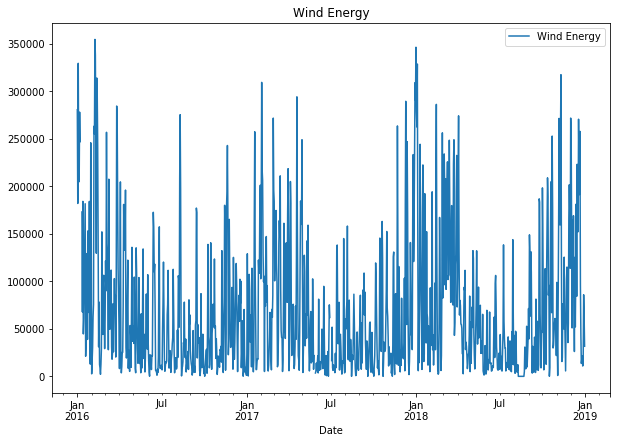

In [6]:
# pintamos la serie
plt.figure(figsize=(22,15))
plt.subplot(2,2,1)
df_eolica_completa['Wind Energy'].plot()
plt.legend()
plt.title('Wind Energy')

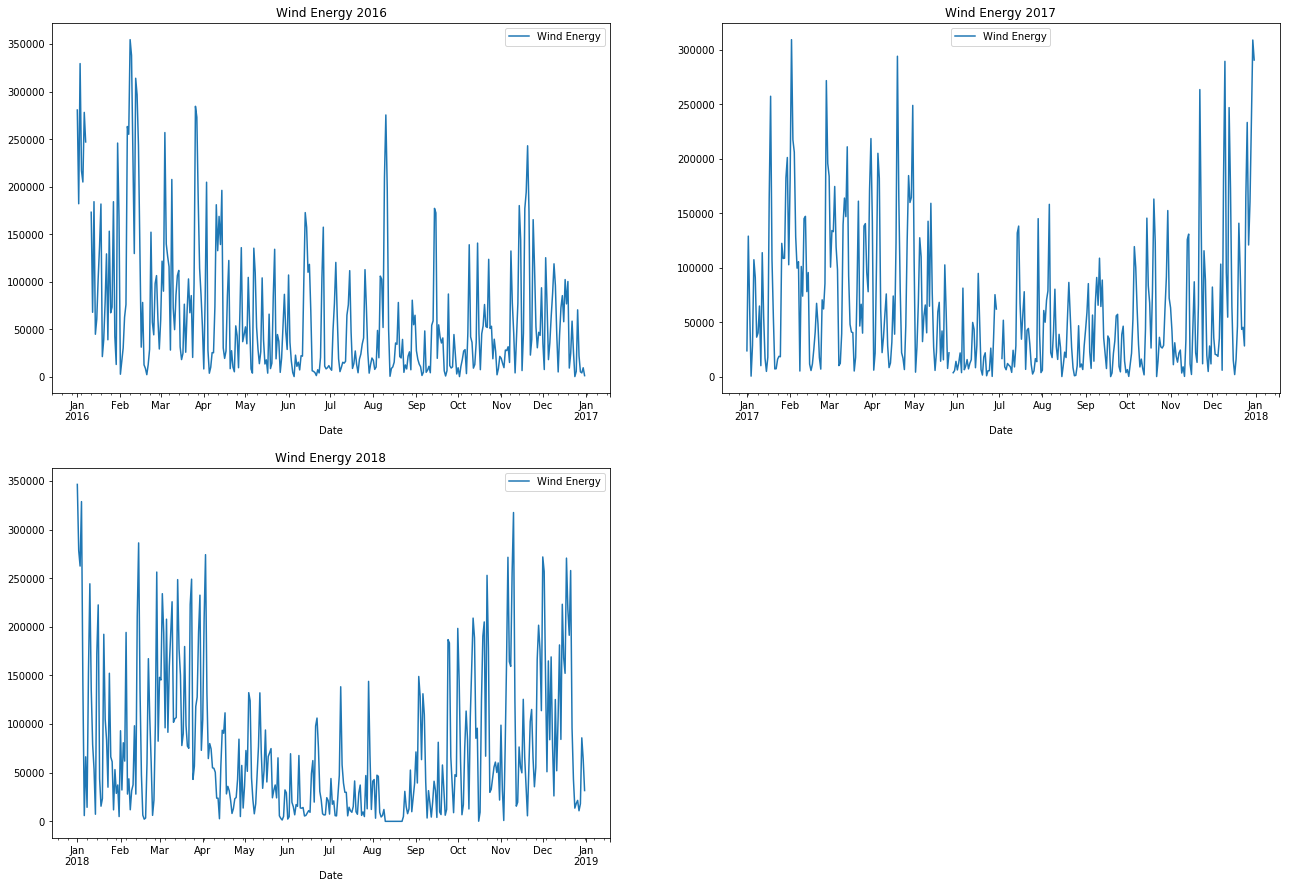

In [7]:
# para intentar verlo algo mejor, pintamos la serie por cada uno de los 3 años de datos
plt.figure(figsize=(22,15))
plt.subplot(2,2,1)
df_eolica_completa['2016-01':'2016-12']['Wind Energy'].plot()
plt.legend()
plt.title('Wind Energy 2016')

plt.subplot(2,2,2)
df_eolica_completa['2017-01':'2017-12']['Wind Energy'].plot()
plt.legend()
plt.title('Wind Energy 2017')

plt.subplot(2,2,3)
df_eolica_completa['2018-01':'2018-12']['Wind Energy'].plot()
plt.legend()
plt.title('Wind Energy 2018');

###### Vistazo a los datos pintados para Wind Energy:
Al pintar las 3 series, por cada uno de los años, se puede apreciar como en los 3 años hay una serie ciertamente similar, y como en los meses de verano hay menor cantidad de energia que tanto en los primeros meses del año como en los últimos meses del año.

Text(0.5,1,'Wind Energy Invierno 2018')

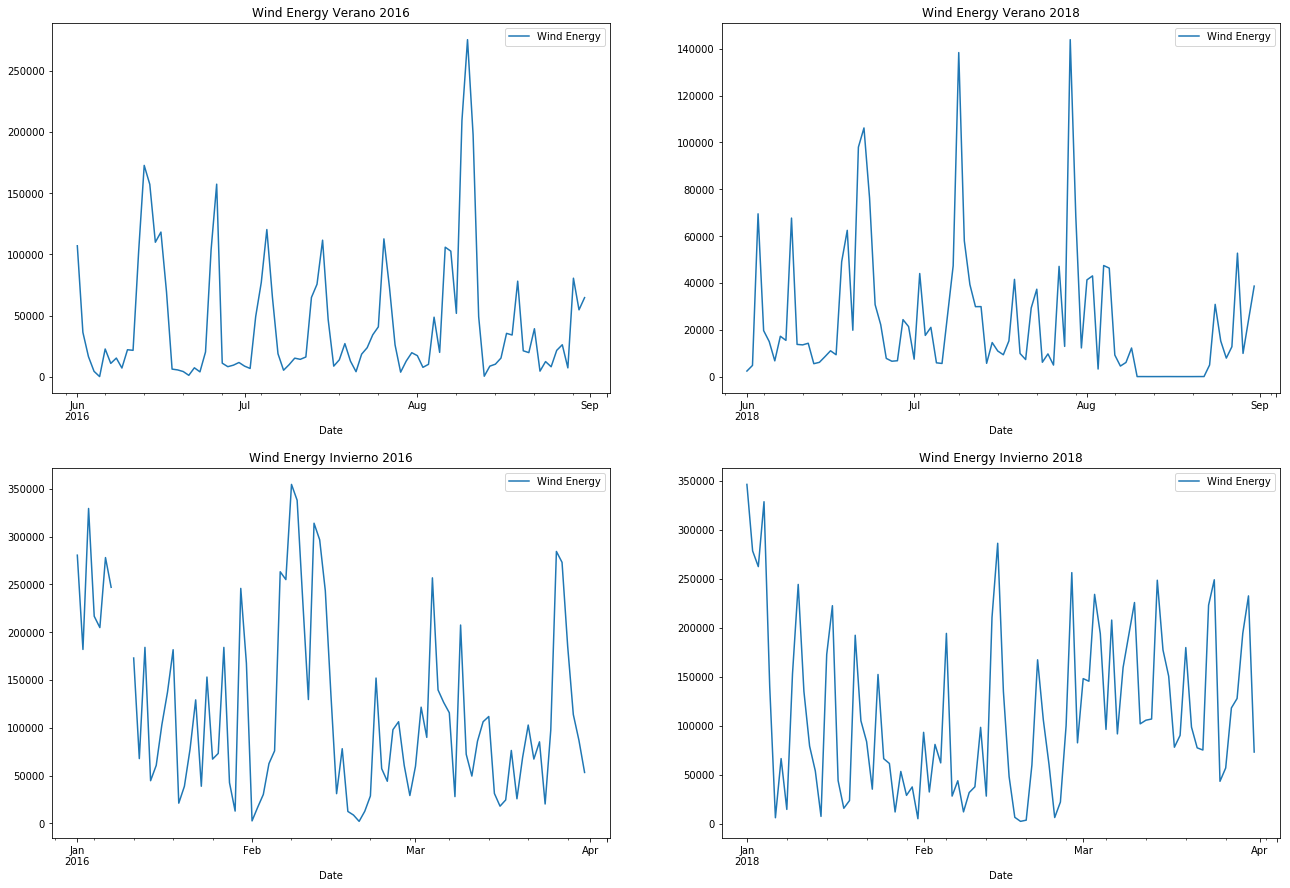

In [8]:
# pintamos un intervalo de 2 meses tanto de 2016 como de 2018, para ver valores en verano e invierno y compararlos
plt.figure(figsize=(22,15))
plt.subplot(2,2,1)
df_eolica_completa['2016-06':'2016-08']['Wind Energy'].plot()
plt.legend()
plt.title('Wind Energy Verano 2016')

plt.subplot(2,2,2)
df_eolica_completa['2018-06':'2018-08']['Wind Energy'].plot()
plt.legend()
plt.title('Wind Energy Verano 2018')

plt.subplot(2,2,3)
df_eolica_completa['2016-01':'2016-03']['Wind Energy'].plot()
plt.legend()
plt.title('Wind Energy Invierno 2016')

plt.subplot(2,2,4)
df_eolica_completa['2018-01':'2018-03']['Wind Energy'].plot()
plt.legend()
plt.title('Wind Energy Invierno 2018')

Se aprecia como ya habíamos visto al ver los años completos, como en invierno los valores son bastante más altos que en verano. Aunque en el verano de 2016 se aprecia un valor bastante alto para esa época, que sería un valor atípico.

¿Hay algún dato que falte? Se aprecia por ejemplo como en el año 2016 parece haber un hueco en los datos. Vamos a verlo mejor.

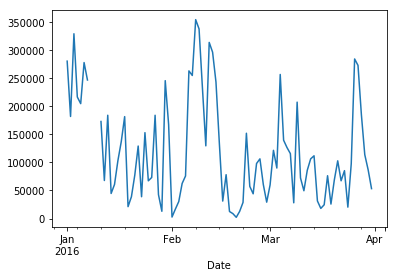

In [9]:
df_eolica_completa['2016-01':'2016-03']['Wind Energy'].plot()

In [10]:
# también usando el siguiente método, si obtenemos True es que tenemos huecos y debemos rellenarlos
df_eolica_completa.isna().any()

Wind Energy    True
dtype: bool

In [11]:
# como se han visto huecos, se usa el método interpolate para rellenar huecos.
df_eolica_int = df_eolica_completa.interpolate(method='linear', axis=0, limit=None, inplace=False,\
                        limit_direction='forward', limit_area=None, downcast=None)

print("num_rows: %d\tColumnas: %d\n" % (df_eolica_int.shape[0], df_eolica_int.shape[1]) )

num_rows: 1096	Columnas: 1



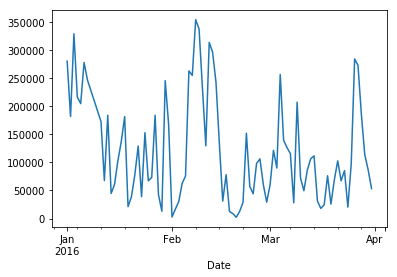

In [12]:
# comprobamos que ya no hay huecos
df_eolica_int['2016-01':'2016-03']['Wind Energy'].plot()

###### Análisis de tendencia y estacionalidad
Ya tenemos la serie sin valores vacíos o faltantas. Usaremos la función seasonal_decompose() para ver si nuestros datos tienen alguna tendencia o estacionalidad.
Hay que usar bien la variable freq para la estacionalidad, y elegir bien si el modelo debe ser aditivo o multiplicativo.

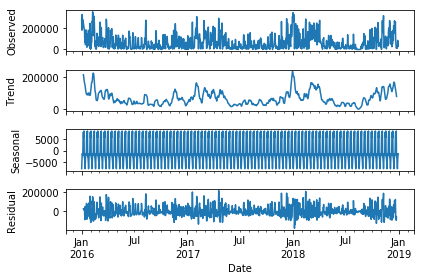

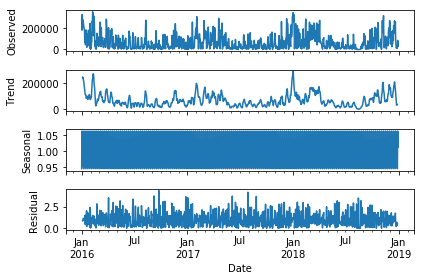

In [13]:
# Ejemplo de descomposición de serie de tiempo modo additive
result = tsa.seasonal_decompose(df_eolica_int['Wind Energy'], model='additive', freq=12)
result.plot();

# para el modo multplicativo hay que eliminar los valores 0.0
df_eolica_int[df_eolica_int == 0.0] = 0.000001
result_mult = tsa.seasonal_decompose(df_eolica_int['Wind Energy'], model = 'multiplicative')
result_mult.plot();

Los datos no parecen estacionales, ni seguir una tendencia clara.

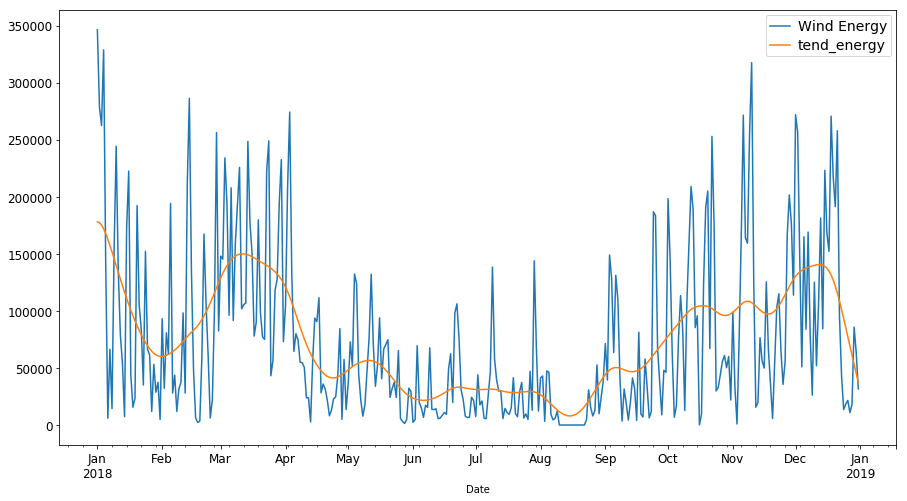

In [14]:
# podemos separar en tendencia y componente cíclico, y pintar ambas líneas
df_eolica_int_ciclo, df_eolica_int_tend = sm.tsa.filters.hpfilter(df_eolica_int['Wind Energy'])
df_eolica_int['tend_energy'] = df_eolica_int_tend

# graficando la variacion de wind energy con la tendencia.
df_eolica_int['2018'][['Wind Energy', 'tend_energy']].plot(figsize=(15, 8), fontsize=12);
legend = plt.legend()
legend.prop.set_size(14);

In [15]:
df_eolica_int.drop(['tend_energy'], axis='columns', inplace=True)

seasonal_decompose() NO quita tendencias ni estacionalidad, solo nos ayuda a analizar la serie. Para quitar estos fenómenos y hacer nuestra serie estacionaria debemos sustituir nuestra serie por una serie de diferencias, para lo que podemos usar la función diff(). diff() permite utilizar como argumento el número de retrasos (la frecuencia en caso de periodos estacionales).

Es mejor para luego entrenar y utilizar los modelos pasar la serie a estacionaria.

La razón por la que las series estacionarias son importantes es que la mayoría de los modelos de series de tiempo funcionan bajo el supuesto de que la serie es estacionaria. Intuitivamente, podemos suponer que si una serie tiene un comportamiento particular en el tiempo, hay una probabilidad muy alta de que se comportamiento continúe en el futuro. Además, las teorías relacionadas con las series estacionarias son más maduras y más fáciles de implementar en comparación con series no estacionarias. A pesar de que el supuesto de que la serie es estacionaria se utiliza en muchos modelos, casi ninguna de las series de tiempo que encontramos en la práctica son estacionarias. Por tal motivo la estadística tuvo que desarrollar varias técnicas para hacer estacionaria, o lo más cercano posible a estacionaria, a una serie.

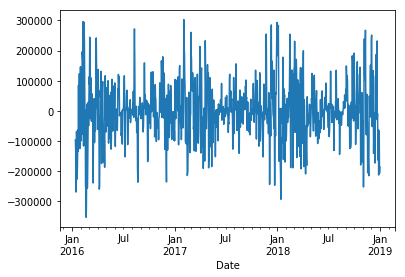

In [16]:
# Si queremos quitar una estacionalidad, el lag tiene que ser el periodo estacional
lag = 12
series_diff_Est = df_eolica_int.diff(lag)
series_diff_Est['Wind Energy'].plot()

In [17]:
#Para quitar tendencias polinómicas diferenciamos tantas veces como el orden del polinomio 
lag = 1
series_sta = df_eolica_int.diff(lag)
series_sta2 = series_sta.diff(lag)

series_stacionary = series_sta2['2016-01-13':'2018-12']

In [19]:
# Guardamos la serie estacionaria en csv para usarla después
series_stacionary.to_csv('series_stacionary.csv', header=True)

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


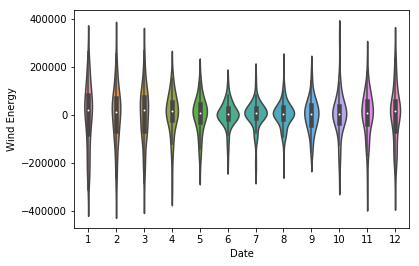

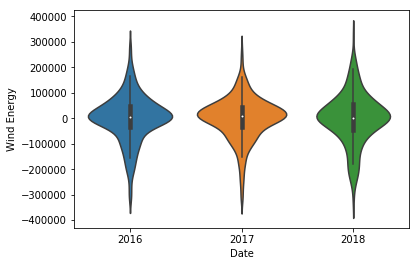

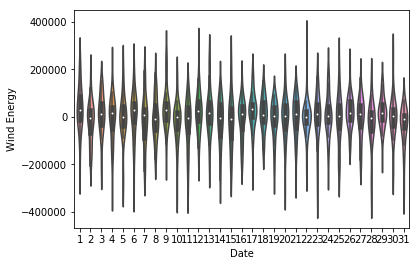

In [20]:
# se pueden ver las distribuciones de los datos con otro tipo de gráficos, y verse por año, mes o día
plt.figure(); sns.violinplot(x=series_stacionary.index.month, y=series_stacionary['Wind Energy']); plt.show()
plt.figure(); sns.violinplot(x=series_stacionary.index.year, y=series_stacionary['Wind Energy']); plt.show()
plt.figure(); sns.violinplot(x=series_stacionary.index.day, y=series_stacionary['Wind Energy']); plt.show()

El último elemento de análisis son los correlogramas y correlogramas parciales. Para ellos podemos usar las funciones **plot_acf()** y **plot_pacf()**. Cuando tenemos series muy largas y estos diagramas nos muestran demasiados retrasos podemos como argumento indicarle cuántos retrasos queremos visualizar (al final los primeros siempre son los más interesantes).

<Figure size 432x288 with 0 Axes>

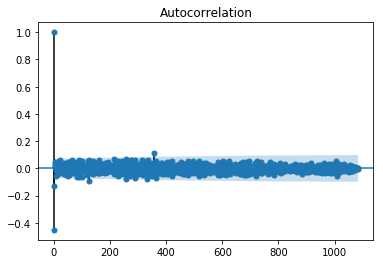

<Figure size 432x288 with 0 Axes>

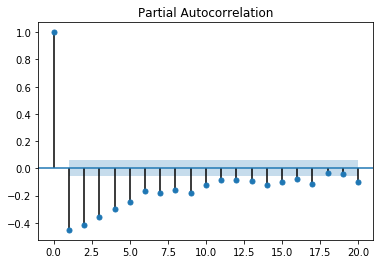

In [21]:
plt.figure(); tsaplots.plot_acf(series_stacionary); plt.show()
plt.figure(); tsaplots.plot_pacf(series_stacionary, lags=20); plt.show()